In [1]:
import torch; print(torch.version.cuda)

10.1


In [2]:
print(torch.__version__)

1.8.1+cu101


In [3]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 11.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 234kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 4.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 4.0MB/s 
     |████████████████████████████████| 215kB 4.0MB/s 
     |████████████████████████████████| 235kB 25.7MB/s 
     |████████████████████████████████| 2.2MB 23.8MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.0-cp37-none-any.whl size=365386 sha256=3a9e31e24d237ecc38cf5766e07b3df7bf835fdcebf78a930bb6eed980007718
  Stored in directory: /root/.cache/pip/wheels/ce/fb/df/37cd43d1433e65b2d3417a71438404d0

## Loading the Planetoid dataset

This dataset looks at the citations between different papers

In [14]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

print(dataset)

Processing...
Done!
Cora()


In [29]:
# print(dir(dataset))
import numpy as np
print(dataset.data.edge_index.numpy())

[[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]


## Plotting the data

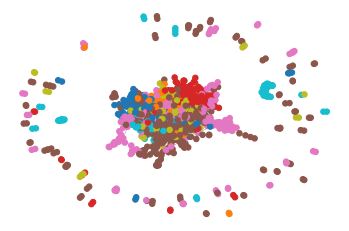

In [33]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(dataset):
  edges_raw = dataset.data.edge_index.numpy()
  edges = [(x,y) for x,y in zip(edges_raw[0,:], edges_raw[1,:])]
  labels = dataset.data.y.numpy()
  G = nx.Graph()
  G.add_nodes_from(list(range(np.max(edges_raw))))
  G.add_edges_from(edges)
  plt.subplot(111)
  options = {'node_size':30, 'width':0.2}
  nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
  plt.show()

plot_dataset(dataset)

  

## Graph convolution network using pytorch geometric

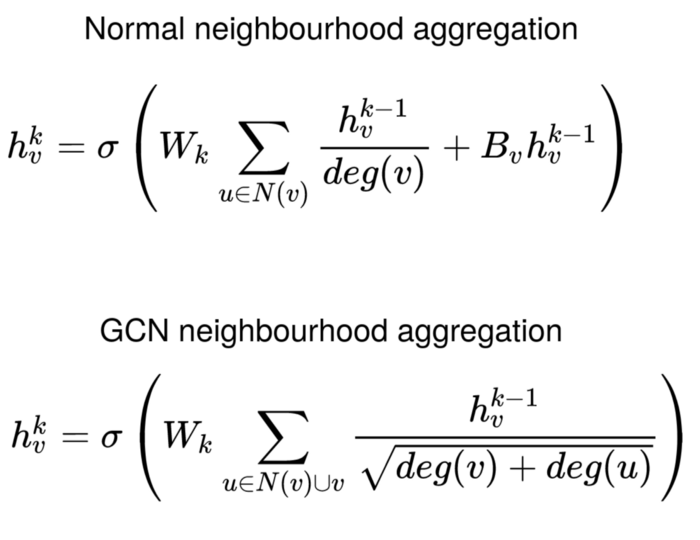

In [11]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F

In [53]:
class GCN(MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(GCN, self).__init__(aggr='add') # we can do different aggregations of messages 
    self.linear = torch.nn.Linear(in_channels, out_channels)

  def forward(self, x, edge_index):
    # add self loops
    # print(' Debug GCN Edge index : {}'.format(edge_index))
    edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0), fill_value=1.0) # if graph was weight fill_value != 1

    # multiply with weights output embedding
    x = self.linear(x)
    # print(' Debug GCN x : {}'.format(x))
    # calculate the nomalization
    row, col = edge_index
    # print('Debug GCN Row : {0} \n Col : {1}'.format(row,col))
    deg = degree(row, x.size(0), dtype=x.dtype)
    # print('Debug GCN Deg : {0}'.format(deg))
    deg_inv_sqrt = deg.pow(-0.5)
    norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

    # propogate embeddings
    return self.propagate(edge_index, size = (x.size(0), x.size(0)), x=x, norm=norm)

  def message(self, x_j, norm):
    # normalize node features
    return norm.view(-1,1)*x_j

### Create NN 

In [13]:
class Net(torch.nn.Module):
  def __init__(self, dataset):
    super(Net,self).__init__()
    self.conv1 = GCN(dataset.num_node_features, 16)
    self.conv2 = GCN(16, dataset.num_classes)
  
  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)

## Training loop

In [52]:
def train(data, plot=False):
  train_acc , test_acc = [], []
  for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # calc_acc
    def calc_acc(data, train=False):
      model.eval()  
      pred = model(data).max(dim=1)[1]
      if train:
        acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum() / len(data.y[data.train_mask])
      else:
        acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum() / len(data.y[data.test_mask])
      # print('Debug acc shape: {0} Debug acc value : {1}'.format(acc.shape, acc.item()))
      return acc.item()

    train_acc.append(calc_acc(data, train=True))
    test_acc.append(calc_acc(data))

    print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc[-1], test_acc[-1]))
    
    if plot:
      plt.plot(train_acc, label="Train accuracy")
      plt.plot(test_acc, label="Validation accuracy")
      plt.xlabel("# Epoch")
      plt.ylabel("Accuracy")
      plt.legend(loc='upper right')
      plt.show()


Epoch: 000, Loss: 1.94951, Train Acc: 0.34286, Test Acc: 0.28000


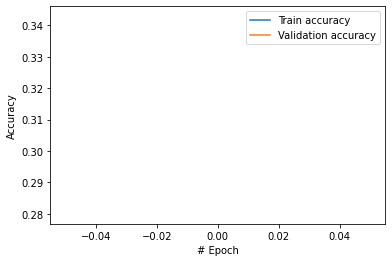

Epoch: 001, Loss: 1.90075, Train Acc: 0.42143, Test Acc: 0.31800


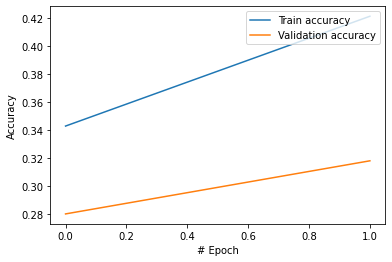

Epoch: 002, Loss: 1.83174, Train Acc: 0.45000, Test Acc: 0.28900


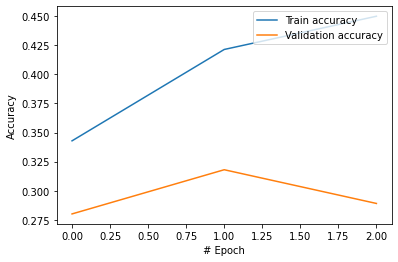

Epoch: 003, Loss: 1.75962, Train Acc: 0.50714, Test Acc: 0.31900


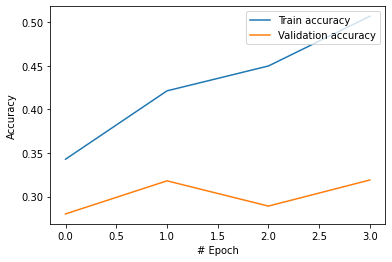

Epoch: 004, Loss: 1.66702, Train Acc: 0.61429, Test Acc: 0.37000


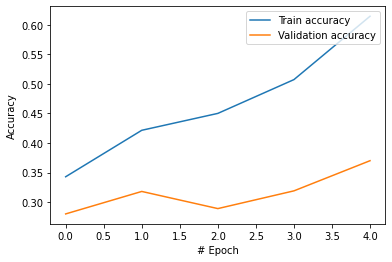

Epoch: 005, Loss: 1.58991, Train Acc: 0.70714, Test Acc: 0.42000


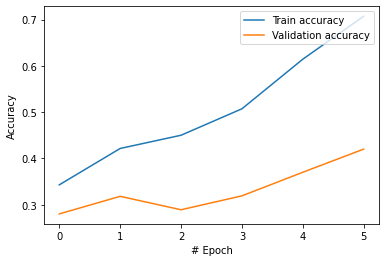

Epoch: 006, Loss: 1.50213, Train Acc: 0.76429, Test Acc: 0.47800


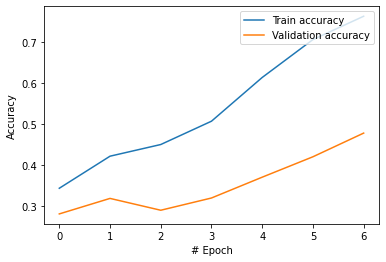

Epoch: 007, Loss: 1.40105, Train Acc: 0.80000, Test Acc: 0.52800


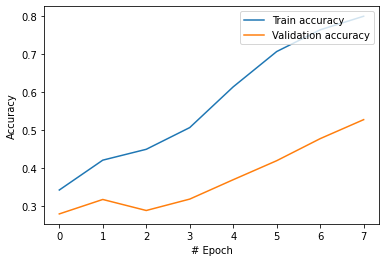

Epoch: 008, Loss: 1.30223, Train Acc: 0.82857, Test Acc: 0.55900


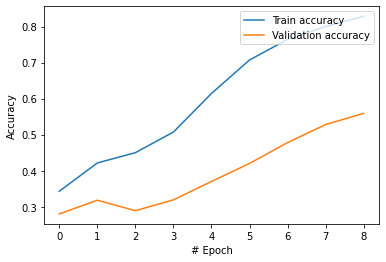

Epoch: 009, Loss: 1.21831, Train Acc: 0.87857, Test Acc: 0.59100


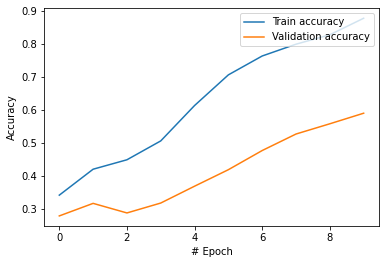

Epoch: 010, Loss: 1.10999, Train Acc: 0.92857, Test Acc: 0.62600


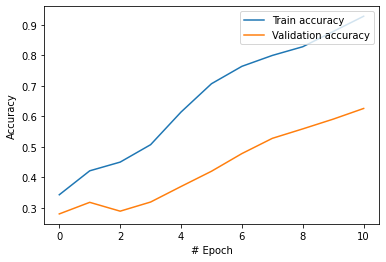

Epoch: 011, Loss: 1.02755, Train Acc: 0.94286, Test Acc: 0.67100


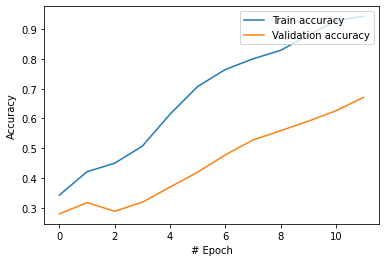

Epoch: 012, Loss: 0.96798, Train Acc: 0.95000, Test Acc: 0.70900


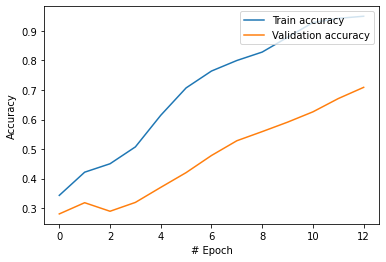

Epoch: 013, Loss: 0.86021, Train Acc: 0.97143, Test Acc: 0.73300


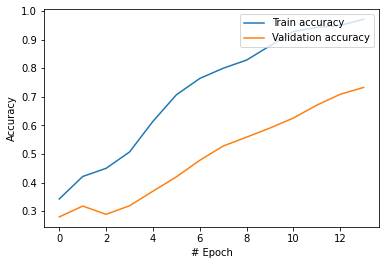

Epoch: 014, Loss: 0.78302, Train Acc: 0.98571, Test Acc: 0.74800


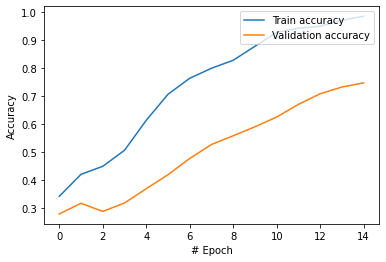

Epoch: 015, Loss: 0.70444, Train Acc: 0.97857, Test Acc: 0.76500


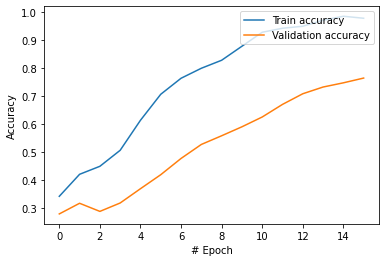

Epoch: 016, Loss: 0.60792, Train Acc: 0.97857, Test Acc: 0.77400


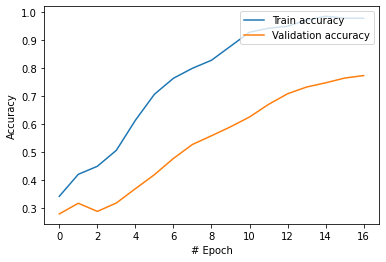

Epoch: 017, Loss: 0.51361, Train Acc: 0.97857, Test Acc: 0.77900


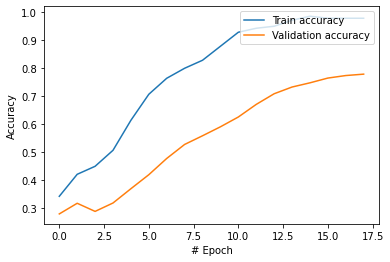

Epoch: 018, Loss: 0.48858, Train Acc: 0.97857, Test Acc: 0.78300


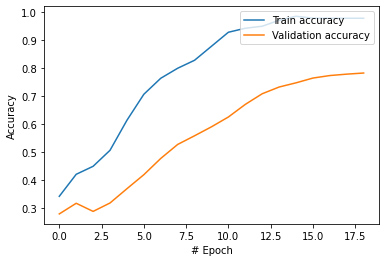

Epoch: 019, Loss: 0.42720, Train Acc: 0.99286, Test Acc: 0.78600


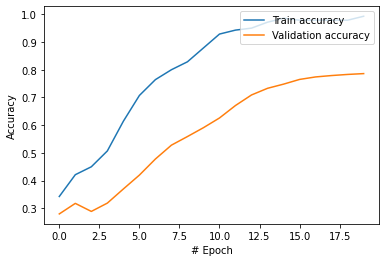

Epoch: 020, Loss: 0.40864, Train Acc: 0.99286, Test Acc: 0.79300


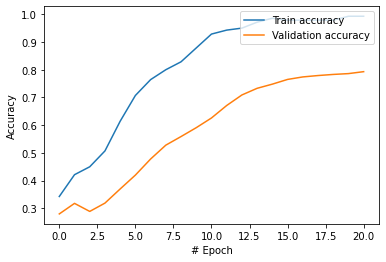

Epoch: 021, Loss: 0.37673, Train Acc: 1.00000, Test Acc: 0.79700


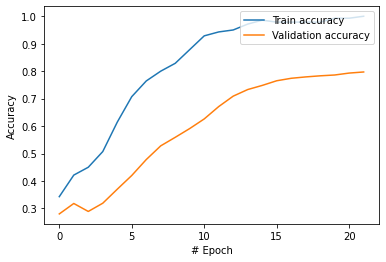

Epoch: 022, Loss: 0.31934, Train Acc: 1.00000, Test Acc: 0.80400


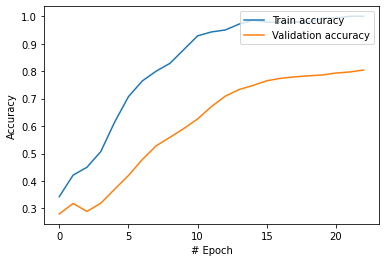

Epoch: 023, Loss: 0.28705, Train Acc: 1.00000, Test Acc: 0.80300


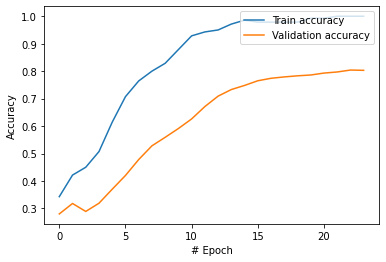

Epoch: 024, Loss: 0.24742, Train Acc: 1.00000, Test Acc: 0.80600


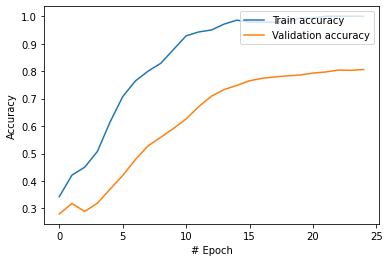

Epoch: 025, Loss: 0.26970, Train Acc: 1.00000, Test Acc: 0.80500


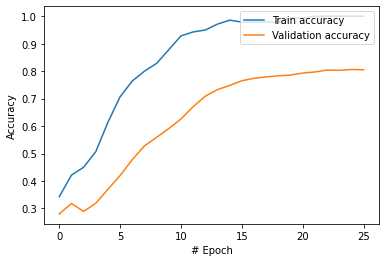

Epoch: 026, Loss: 0.24587, Train Acc: 1.00000, Test Acc: 0.80400


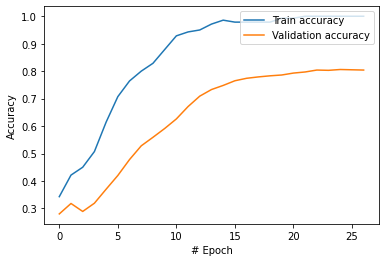

Epoch: 027, Loss: 0.22167, Train Acc: 1.00000, Test Acc: 0.80400


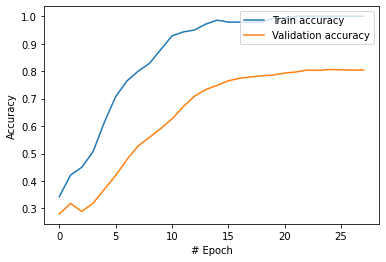

Epoch: 028, Loss: 0.16079, Train Acc: 1.00000, Test Acc: 0.80200


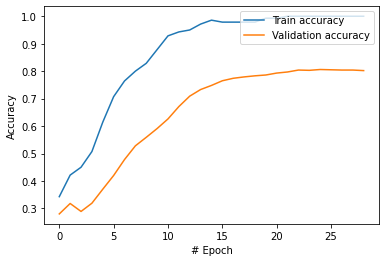

Epoch: 029, Loss: 0.15152, Train Acc: 1.00000, Test Acc: 0.80300


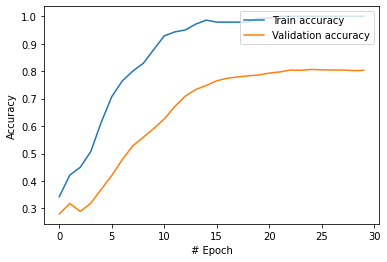

Epoch: 030, Loss: 0.15221, Train Acc: 1.00000, Test Acc: 0.80100


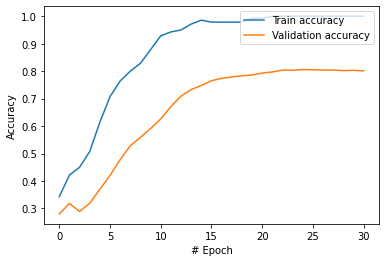

Epoch: 031, Loss: 0.12852, Train Acc: 1.00000, Test Acc: 0.79800


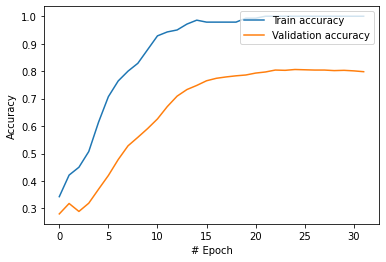

Epoch: 032, Loss: 0.10697, Train Acc: 1.00000, Test Acc: 0.79600


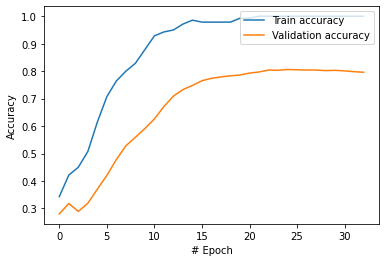

Epoch: 033, Loss: 0.08776, Train Acc: 1.00000, Test Acc: 0.79500


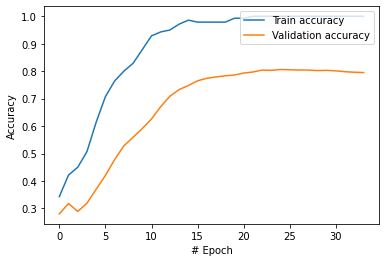

Epoch: 034, Loss: 0.16938, Train Acc: 1.00000, Test Acc: 0.79000


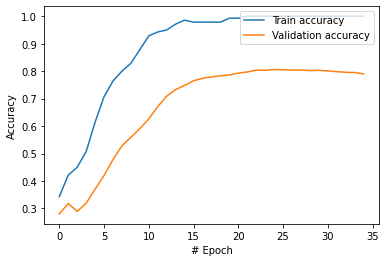

Epoch: 035, Loss: 0.09844, Train Acc: 1.00000, Test Acc: 0.78500


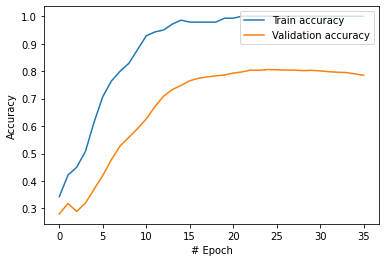

Epoch: 036, Loss: 0.09876, Train Acc: 1.00000, Test Acc: 0.78600


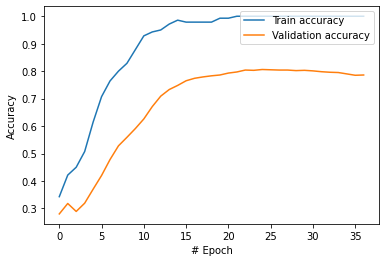

Epoch: 037, Loss: 0.09619, Train Acc: 1.00000, Test Acc: 0.78700


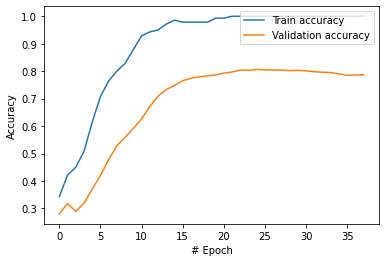

Epoch: 038, Loss: 0.09646, Train Acc: 1.00000, Test Acc: 0.78700


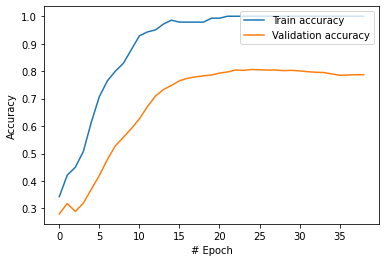

Epoch: 039, Loss: 0.06755, Train Acc: 1.00000, Test Acc: 0.78800


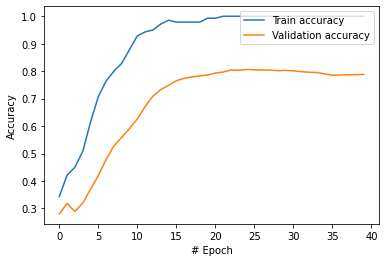

Epoch: 040, Loss: 0.08496, Train Acc: 1.00000, Test Acc: 0.78800


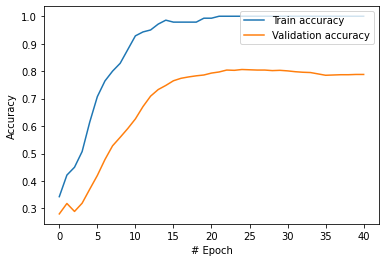

Epoch: 041, Loss: 0.06803, Train Acc: 1.00000, Test Acc: 0.78500


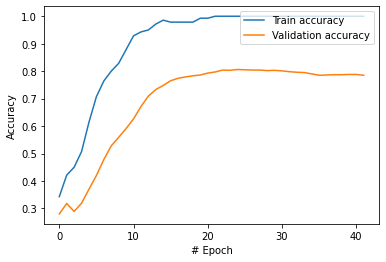

Epoch: 042, Loss: 0.08865, Train Acc: 1.00000, Test Acc: 0.78500


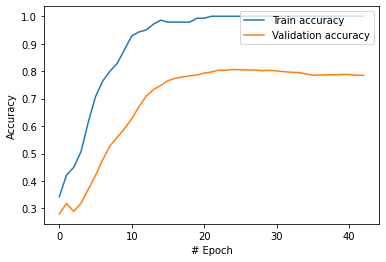

Epoch: 043, Loss: 0.06357, Train Acc: 1.00000, Test Acc: 0.78700


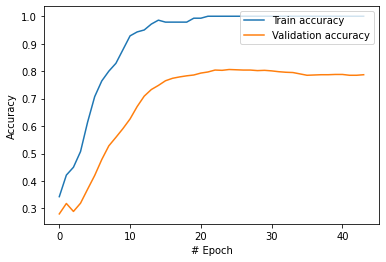

Epoch: 044, Loss: 0.06504, Train Acc: 1.00000, Test Acc: 0.78700


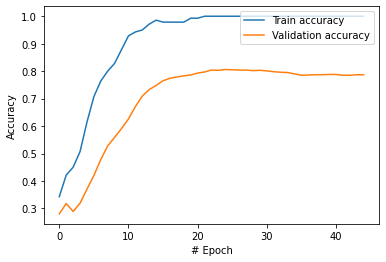

Epoch: 045, Loss: 0.07941, Train Acc: 1.00000, Test Acc: 0.78900


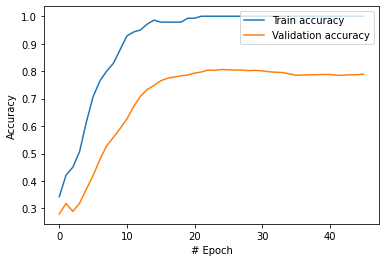

Epoch: 046, Loss: 0.05903, Train Acc: 1.00000, Test Acc: 0.79200


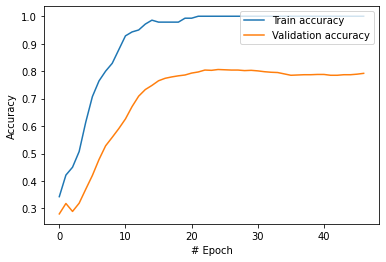

Epoch: 047, Loss: 0.04482, Train Acc: 1.00000, Test Acc: 0.79300


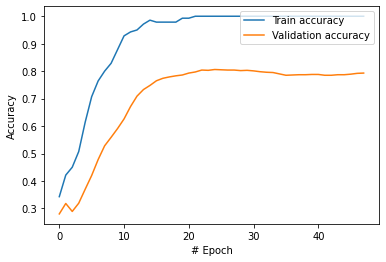

Epoch: 048, Loss: 0.05522, Train Acc: 1.00000, Test Acc: 0.79300


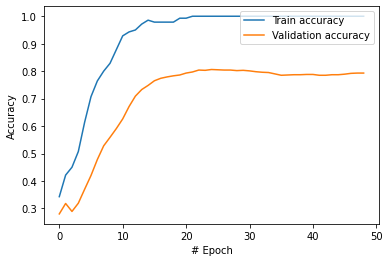

Epoch: 049, Loss: 0.06597, Train Acc: 1.00000, Test Acc: 0.79300


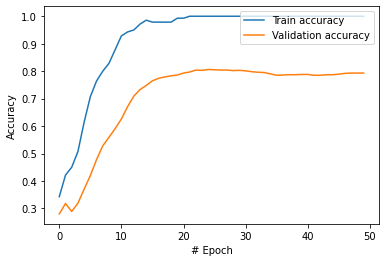

Epoch: 050, Loss: 0.05753, Train Acc: 1.00000, Test Acc: 0.79400


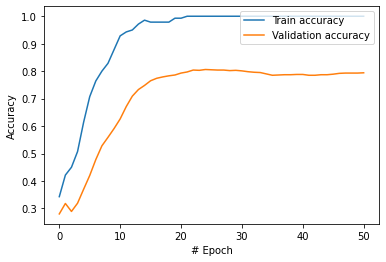

Epoch: 051, Loss: 0.07469, Train Acc: 1.00000, Test Acc: 0.79300


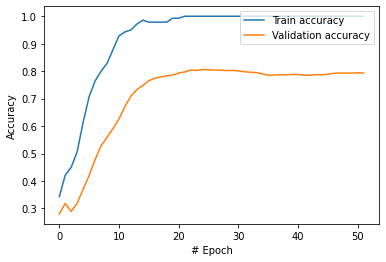

Epoch: 052, Loss: 0.07031, Train Acc: 1.00000, Test Acc: 0.79500


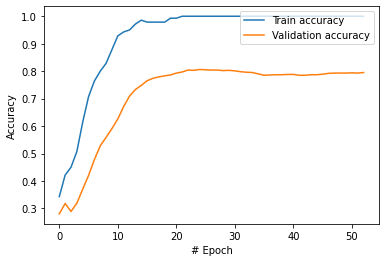

Epoch: 053, Loss: 0.08536, Train Acc: 1.00000, Test Acc: 0.79600


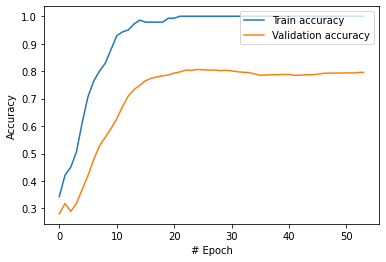

Epoch: 054, Loss: 0.05926, Train Acc: 1.00000, Test Acc: 0.79500


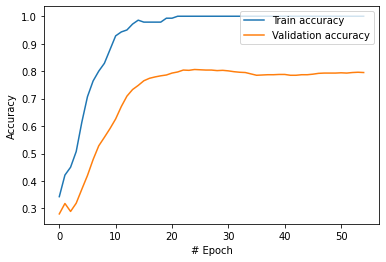

Epoch: 055, Loss: 0.03772, Train Acc: 1.00000, Test Acc: 0.79500


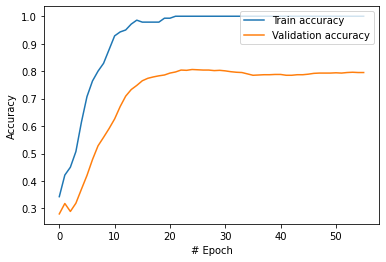

Epoch: 056, Loss: 0.07043, Train Acc: 1.00000, Test Acc: 0.79200


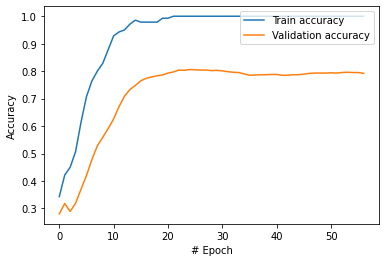

Epoch: 057, Loss: 0.05497, Train Acc: 1.00000, Test Acc: 0.79400


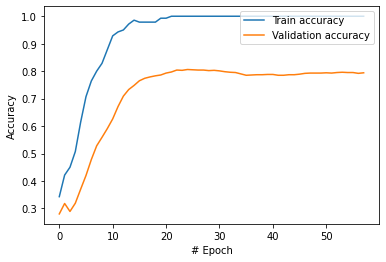

Epoch: 058, Loss: 0.04364, Train Acc: 1.00000, Test Acc: 0.79500


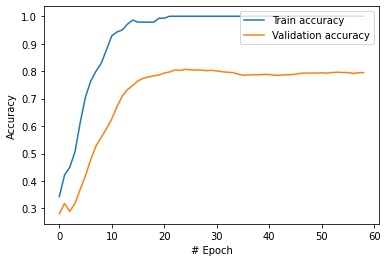

Epoch: 059, Loss: 0.06115, Train Acc: 1.00000, Test Acc: 0.79500


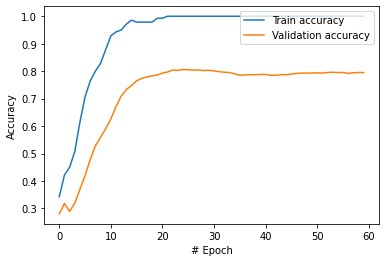

Epoch: 060, Loss: 0.04746, Train Acc: 1.00000, Test Acc: 0.79400


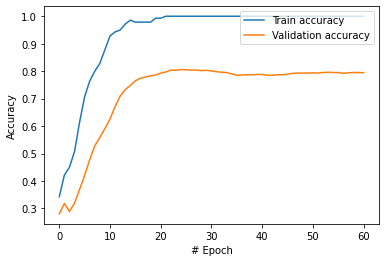

Epoch: 061, Loss: 0.05697, Train Acc: 1.00000, Test Acc: 0.79500


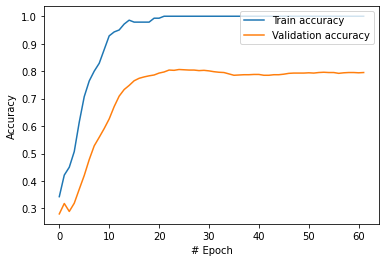

Epoch: 062, Loss: 0.05861, Train Acc: 1.00000, Test Acc: 0.79800


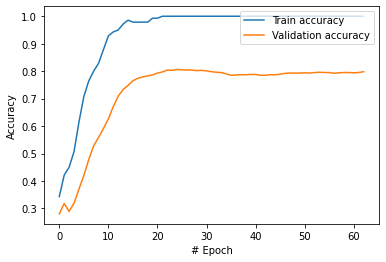

Epoch: 063, Loss: 0.05558, Train Acc: 1.00000, Test Acc: 0.80000


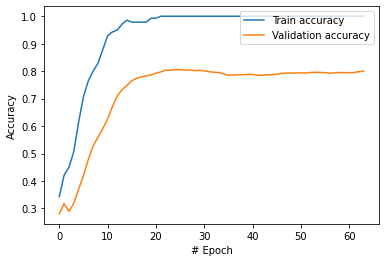

Epoch: 064, Loss: 0.04554, Train Acc: 1.00000, Test Acc: 0.79900


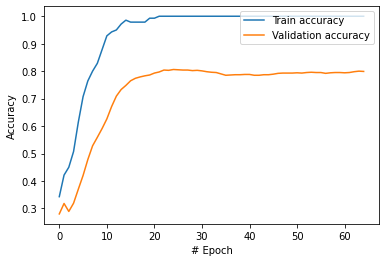

Epoch: 065, Loss: 0.05197, Train Acc: 1.00000, Test Acc: 0.79800


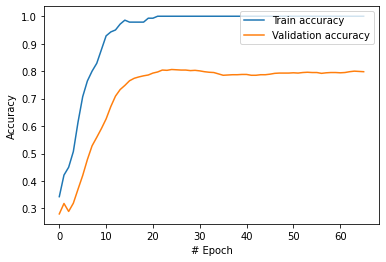

Epoch: 066, Loss: 0.04285, Train Acc: 1.00000, Test Acc: 0.79700


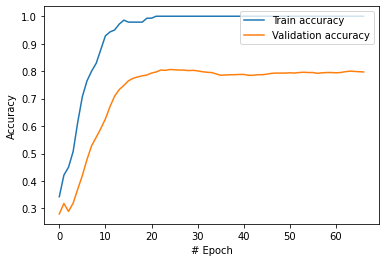

Epoch: 067, Loss: 0.04059, Train Acc: 1.00000, Test Acc: 0.79800


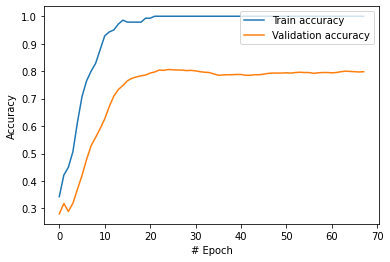

Epoch: 068, Loss: 0.05221, Train Acc: 1.00000, Test Acc: 0.80100


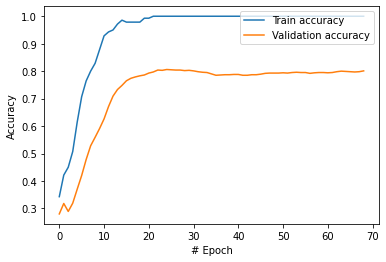

Epoch: 069, Loss: 0.05444, Train Acc: 1.00000, Test Acc: 0.80300


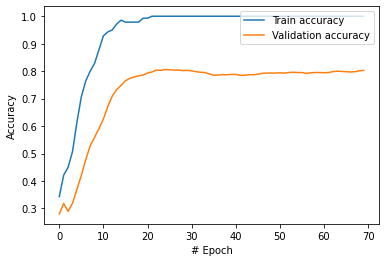

Epoch: 070, Loss: 0.04292, Train Acc: 1.00000, Test Acc: 0.80200


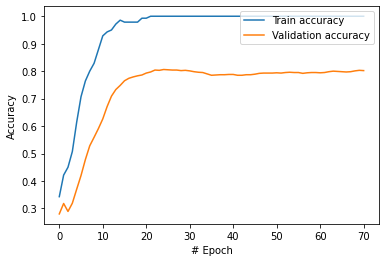

Epoch: 071, Loss: 0.06122, Train Acc: 1.00000, Test Acc: 0.80200


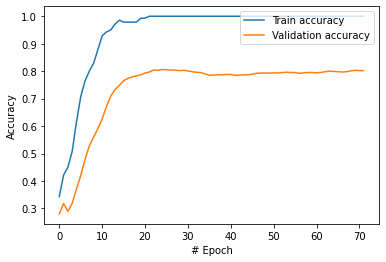

Epoch: 072, Loss: 0.05046, Train Acc: 1.00000, Test Acc: 0.80300


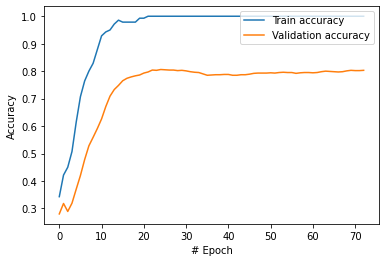

Epoch: 073, Loss: 0.03260, Train Acc: 1.00000, Test Acc: 0.80000


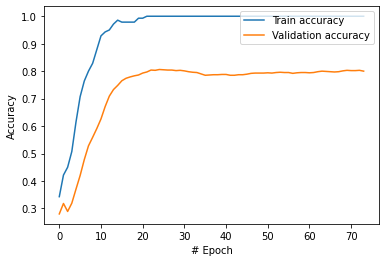

Epoch: 074, Loss: 0.05451, Train Acc: 1.00000, Test Acc: 0.79800


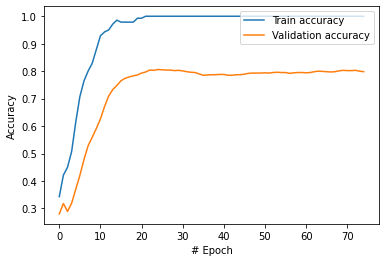

Epoch: 075, Loss: 0.04579, Train Acc: 1.00000, Test Acc: 0.79800


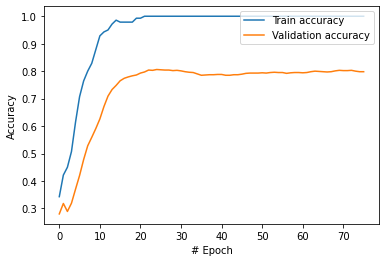

Epoch: 076, Loss: 0.06213, Train Acc: 1.00000, Test Acc: 0.80000


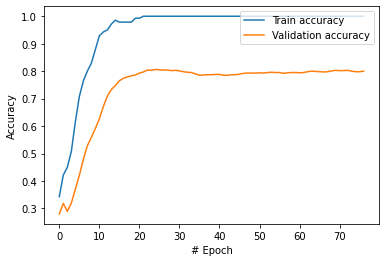

Epoch: 077, Loss: 0.04449, Train Acc: 1.00000, Test Acc: 0.79700


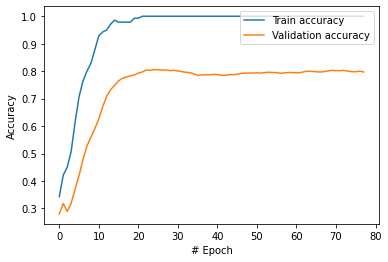

Epoch: 078, Loss: 0.03899, Train Acc: 1.00000, Test Acc: 0.79500


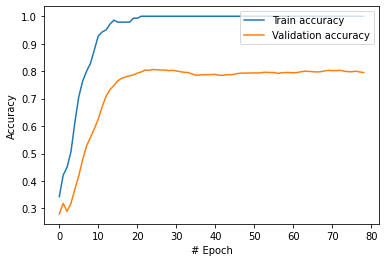

Epoch: 079, Loss: 0.04178, Train Acc: 1.00000, Test Acc: 0.79800


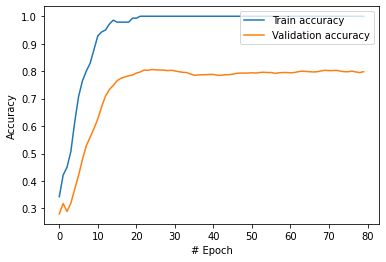

Epoch: 080, Loss: 0.05889, Train Acc: 1.00000, Test Acc: 0.79800


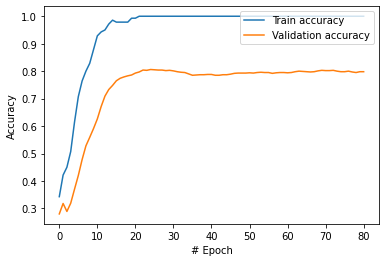

Epoch: 081, Loss: 0.04863, Train Acc: 1.00000, Test Acc: 0.79900


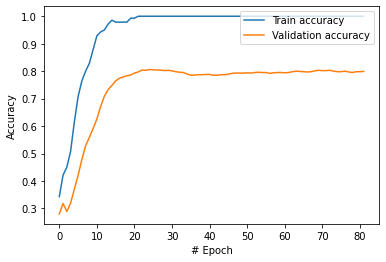

Epoch: 082, Loss: 0.05330, Train Acc: 1.00000, Test Acc: 0.79900


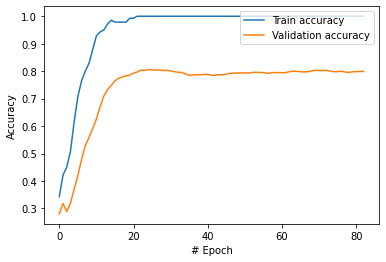

Epoch: 083, Loss: 0.06043, Train Acc: 1.00000, Test Acc: 0.79700


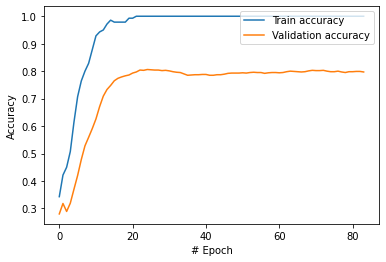

Epoch: 084, Loss: 0.05805, Train Acc: 1.00000, Test Acc: 0.79700


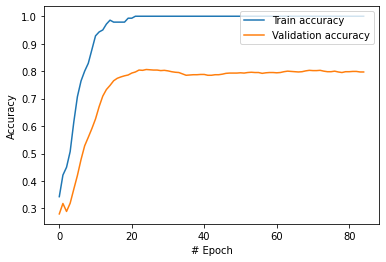

Epoch: 085, Loss: 0.05207, Train Acc: 1.00000, Test Acc: 0.79800


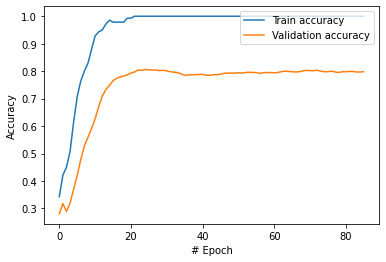

Epoch: 086, Loss: 0.05592, Train Acc: 1.00000, Test Acc: 0.79700


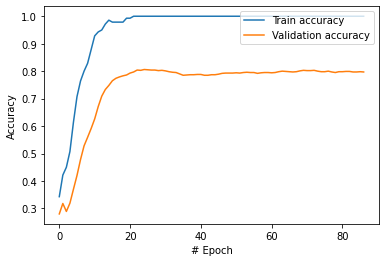

Epoch: 087, Loss: 0.04481, Train Acc: 1.00000, Test Acc: 0.80100


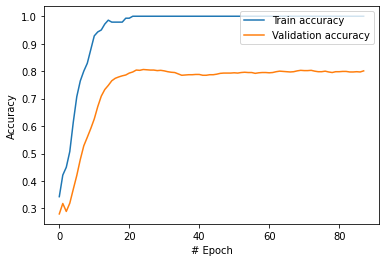

Epoch: 088, Loss: 0.04000, Train Acc: 1.00000, Test Acc: 0.80400


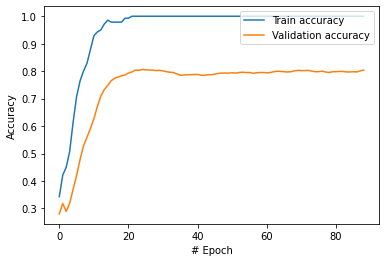

Epoch: 089, Loss: 0.05204, Train Acc: 1.00000, Test Acc: 0.80400


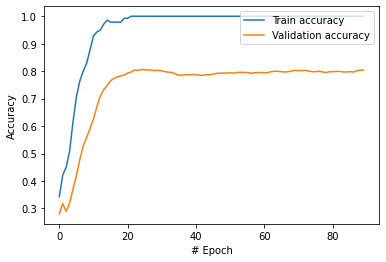

Epoch: 090, Loss: 0.05076, Train Acc: 1.00000, Test Acc: 0.80300


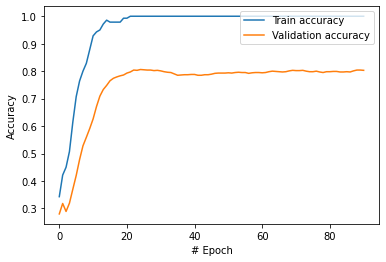

Epoch: 091, Loss: 0.03976, Train Acc: 1.00000, Test Acc: 0.80300


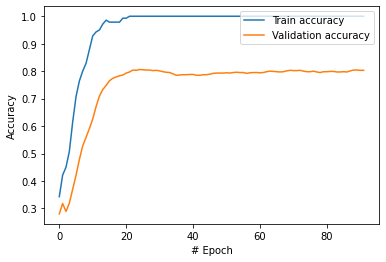

Epoch: 092, Loss: 0.04142, Train Acc: 1.00000, Test Acc: 0.80200


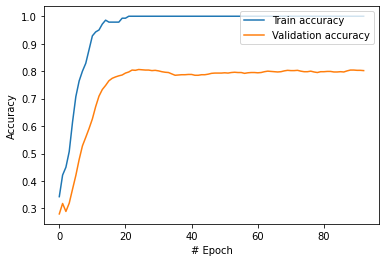

Epoch: 093, Loss: 0.05317, Train Acc: 1.00000, Test Acc: 0.80500


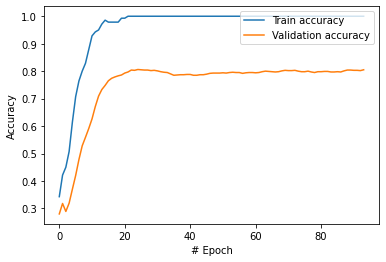

Epoch: 094, Loss: 0.03647, Train Acc: 1.00000, Test Acc: 0.80500


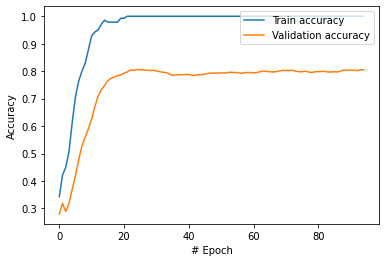

Epoch: 095, Loss: 0.05834, Train Acc: 1.00000, Test Acc: 0.80500


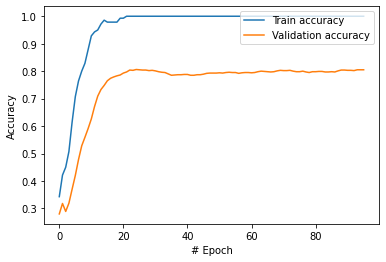

Epoch: 096, Loss: 0.04417, Train Acc: 1.00000, Test Acc: 0.80500


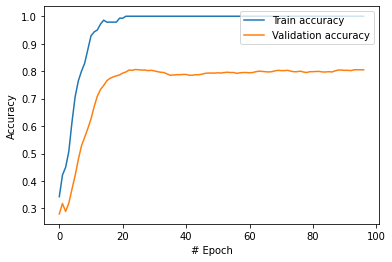

Epoch: 097, Loss: 0.05712, Train Acc: 1.00000, Test Acc: 0.80400


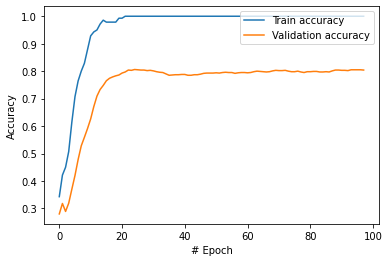

Epoch: 098, Loss: 0.03089, Train Acc: 1.00000, Test Acc: 0.80400


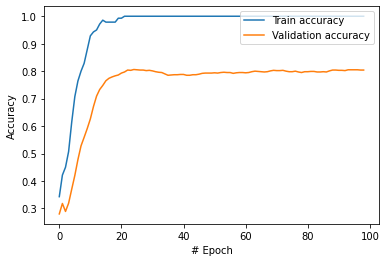

Epoch: 099, Loss: 0.05638, Train Acc: 1.00000, Test Acc: 0.80400


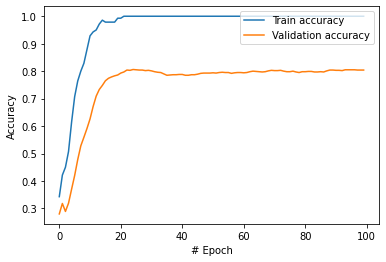

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train(data, plot=True)

In [41]:
print(type(dataset[0]))

<class 'torch_geometric.data.data.Data'>
